# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [16]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import sagemaker
import boto3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sagemaker.tuner import IntegerParameter, ContinuousParameter, CategoricalParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [8]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget --no-check-certificate https://udacity-ml-aws.s3.us-east-2.amazonaws.com/udacity-ml-aws/dogImages.zip
#!aws s3 cp s3://udacity-ml-aws/dogImages.zip $HOME/dogImages.zip

--2024-07-31 21:32:26--  https://udacity-ml-aws.s3.us-east-2.amazonaws.com/udacity-ml-aws/dogImages.zip
Resolving udacity-ml-aws.s3.us-east-2.amazonaws.com (udacity-ml-aws.s3.us-east-2.amazonaws.com)... 52.219.177.138, 3.5.129.113, 3.5.132.185, ...
Connecting to udacity-ml-aws.s3.us-east-2.amazonaws.com (udacity-ml-aws.s3.us-east-2.amazonaws.com)|52.219.177.138|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 403 Forbidden
2024-07-31 21:32:26 ERROR 403: Forbidden.



In [10]:
#!unzip dogImages.zip
!unzip $HOME/dogImages.zip -d $HOME

Archive:  /home/sagemaker-user/dogImages.zip
   creating: /home/sagemaker-user/dogImages/
   creating: /home/sagemaker-user/dogImages/test/
   creating: /home/sagemaker-user/dogImages/train/
   creating: /home/sagemaker-user/dogImages/valid/
   creating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: /home/sagemaker-user/dogIm

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

Answer: I'm using the dog breed classification dataset. 
There are 133 dog breeds in the dataset. The dataset is split into 3 folders, train, test, valid. Each folder contains 133 subfolders. Each subfolder contains images of a particular dog breed.
The structure of the dataset 
```bash
.
├── train
│   ├── 001.Affenpinscher
│      ├── Affenpinscher_00001.jpg
│      ├── Affenpinscher_00002.jpg
│      ├── ....
├── test
│   ├── 001.Affenpinscher
│      ├── Affenpinscher_000036.jpg
│      ├── ...
├── valid
│   ├── 001.Affenpinscher
│      ├── Affenpinscher_000038.jpg
│      ├── ...
```
Makes it so that the classification of each image is done by the name of the folder.

Each image is between 30kb and 100kb in jpg format. Their dimensions differ in both width and height.

Here are examples of two images:


In [2]:
# get home directory

home = os.path.expanduser("~")

data_dir =  os.path.join(home, 'dogImages')
test_dir = os.path.join(data_dir, 'test')
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
bucket_name = 'udacity-ml-aws'
s3_dataset_path = f's3://{bucket_name}/dogImages'



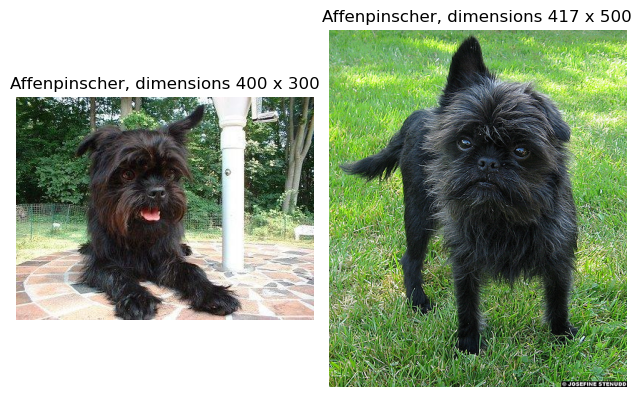

In [3]:
# open 
first_path = os.path.join(train_dir, '001.Affenpinscher', 'Affenpinscher_00001.jpg')
second_path = os.path.join(train_dir, '001.Affenpinscher', 'Affenpinscher_00033.jpg')
image1 = mpimg.imread(first_path)
image2 = mpimg.imread(second_path)

height1, width1, channels1 = image1.shape
height2, width2, channels2 = image2.shape

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2)

# Display the first image
axs[0].imshow(image1)
axs[0].set_title(f'Affenpinscher, dimensions {width1} x {height1}')

axs[0].axis('off')

# Display the second image
axs[1].imshow(image2)
axs[1].set_title(f'Affenpinscher, dimensions {width2} x {height2}')
axs[1].axis('off')


# Adjust layout
plt.tight_layout()
plt.show()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [37]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile, Rule, ProfilerRule, rule_configs
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

#TODO: Declare your HP ranges, metrics etc.
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)
hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(1e-4, 1e-2, scaling_type="Logarithmic"),
    'batch_size': CategoricalParameter([32, 64, 128]),
    'dropout_rate': ContinuousParameter(0.1, 0.5),
    'optimizer': CategoricalParameter(['adam', 'sgd', 'rmsprop']),
    'fc_layer_size': IntegerParameter(64, 256),
}

#TODO: Create estimators for your HPs
# TODO: Your estimator here
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g5.2xlarge",
    #instance_type="ml.m5.xlarge",
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    entry_point="hpo.py",  # Replace with your actual script name
    rules=rules,
    debugger_hook_config=hook_config,
    hyperparameters={
        'epochs': 8,  # We set this as fixed, but you can make it tunable if you prefer
        'model_dir': '/opt/ml/model',
        's3_data_path': s3_dataset_path
    }
)
# TODO: Your HP tuner here
objective_metric_name = 'test:accuracy'
objective_type = 'Maximize'
metric_definitions = [
    {'Name': 'test:accuracy', 'Regex': 'Test set: .*Accuracy: [0-9]+/[0-9]+ \\(([0-9\\.]+)%\\)'}
]

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)

# Configure the data channels
data_channels = {
    'train': f'{s3_dataset_path}/train',
    'validation': f'{s3_dataset_path}/valid',
    'test': f'{s3_dataset_path}/test',
}

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [38]:
# TODO: Fit your HP Tuner
tuner.fit(data_channels, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = 

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

estimator = # TODO: Your estimator here

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()